In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'],date_parser=dateparse)
print(data.dtypes)

data.rename(columns={'Month': 'date', '#Passengers': 'Passengers'},inplace=True)

Month          datetime64[ns]
#Passengers             int64
dtype: object


In [3]:
data

,date,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [4]:
data.isna().sum()

final_data= data.copy()

In [5]:
final_data.set_index('date', inplace=True)

In [6]:
final_data.head()

,Passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Plotting Data

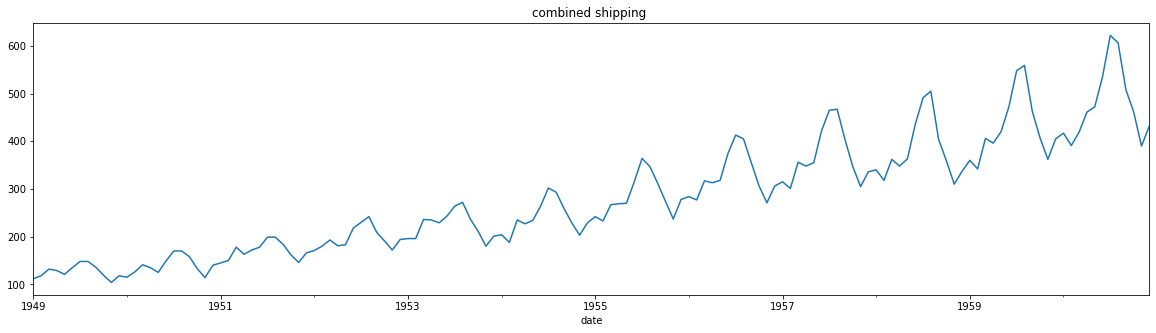

In [7]:
final_data.Passengers.plot(figsize=(20,5), title = "combined shipping ")
plt.show()

### The QQ Plot

In [8]:
import scipy.stats
import pylab


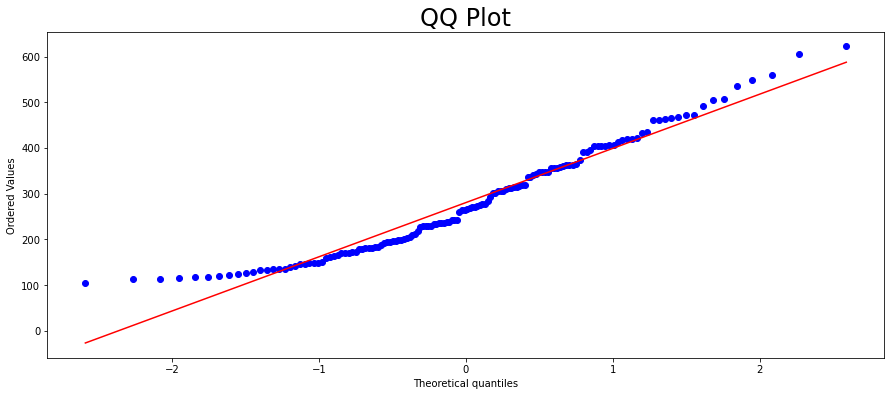

In [9]:
# check data distributed how it fits normal ditribution, take all values and arranges them in order 
# how many standard deviation away from the mean, red line represents pure normal ditribution line

scipy.stats.probplot(final_data.Passengers, plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

## confirming trend

Text(0.5, 0, 'Year')

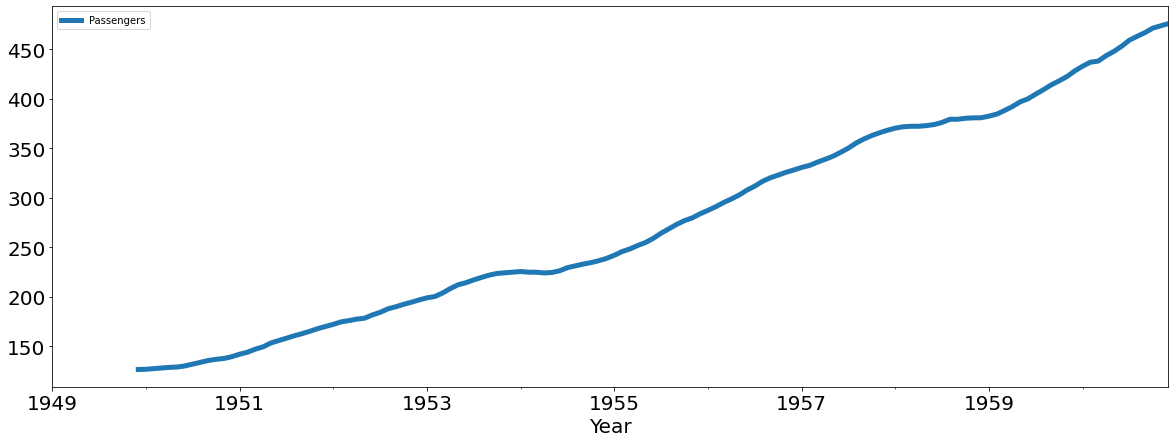

In [10]:
p= final_data[['Passengers']]
p.rolling(12).mean().plot(figsize=(20,7), linewidth= 5, fontsize=20)
plt.xlabel('Year', fontsize=20)

## confirming seasonal

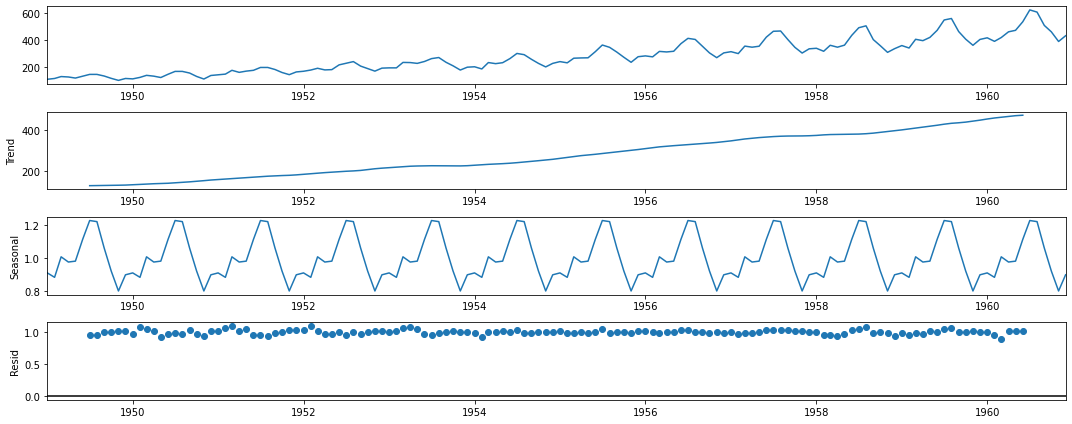

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(final_data, model='multiplicative')

result.plot()
plt.show()

## Checking stationarity

In [12]:
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt 

In [13]:
adf_stat= sts.adfuller(final_data.Passengers)
print('ADF Statistic: %f' % adf_stat[0])
print('p-value: %f' % adf_stat[1])
print('Critical Values:')
for key, value in adf_stat[4].items():
    print('\t%s: %.3f' % (key, value))


# higher p-value which states it is not stationary data also test stat is more 

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


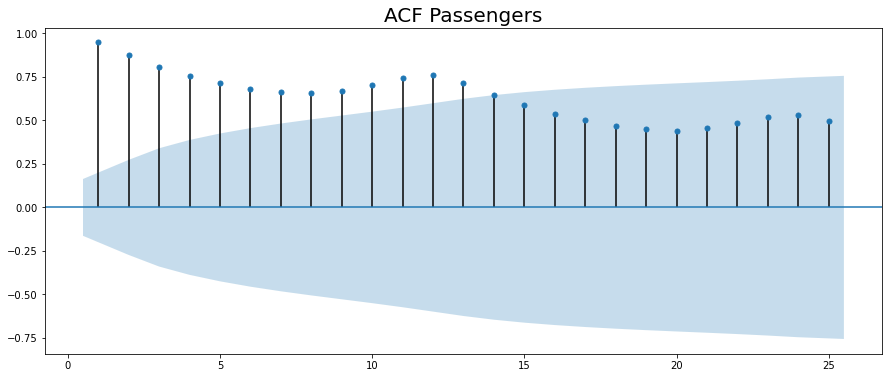

In [14]:
sgt.plot_acf(final_data.Passengers, lags = 25, zero = False)
plt.title("ACF Passengers", size = 20)
plt.show()

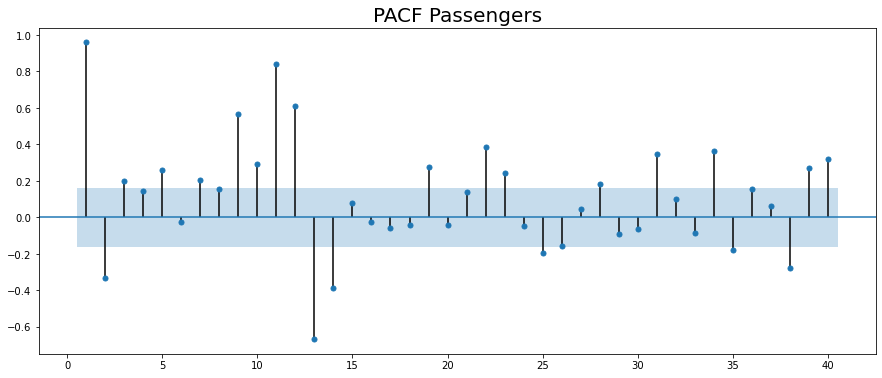

In [15]:
sgt.plot_pacf(final_data.Passengers, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Passengers", size = 20)
plt.show()

## Grid search

In [16]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [17]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def measure_mape(actual, predicted):
    mape_value= np.abs(actual - predicted).sum()/actual.sum()
    return mape_value

def arima_function(history, arima_order):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    
    aic= model_fit.aic
    
    return yhat,aic, model_fit

def evaluate_arima_model(X, arima_order, test_size):
    train_size = int(len(X) * test_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        yhat,aic, model_fit = arima_function(history, arima_order)
        predictions.append(yhat)
        history.append(test[t])
    
    rmse = measure_rmse(test, predictions)
    mape = measure_mape(test, predictions)
    return rmse, aic, model_fit, mape
 
def evaluate_models(dataset, p_values, d_values, q_values, test_size):
    dataset = dataset.astype('float32')
    best_score, best_cfg, best_aic = float("inf"), None, float("inf")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse,aic, model_fit,mape = evaluate_arima_model(dataset, order, test_size)
                    if ((rmse < best_score) & (aic < best_aic)):
                        best_score, best_cfg, best_aic,best_modell,best_mape = rmse, order, aic, model_fit, mape
                        model_fit.save('best_arima_model.pkl')
#                     print('ARIMA%s RMSE=%.3f AIC=%.3f MAPE= %.3f' % (order,rmse,aic, mape))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f AIC=%.3f MAPE=%.3f' % (best_cfg, best_score, best_aic, mape))
    
    return best_cfg, best_score, best_aic, mape

In [18]:
p_values = [0, 1, 2, 3, 4]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
test_size= 0.80
best_cfg, best_score, best_aic, best_mape = evaluate_models(final_data.values, p_values, d_values, q_values, test_size)

Best ARIMA(2, 1, 3) RMSE=38.573 AIC=1329.414 MAPE=0.095


In [19]:
from statsmodels.tsa.arima_model import ARIMAResults

loaded = ARIMAResults.load('best_arima_model.pkl')

### Re-fit with best model

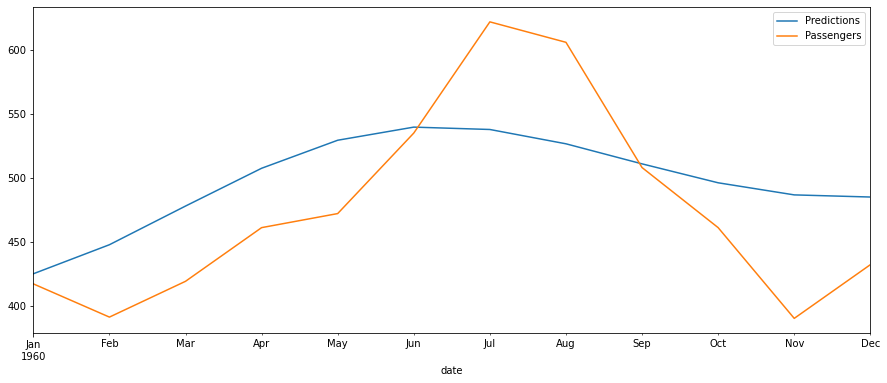

In [20]:
train = final_data.iloc[:len(final_data)-12]
test = final_data.iloc[len(final_data)-12:] 


start = len(train)
end = len(train) + len(test) - 1
  
    
best_arima = ARIMA(train['Passengers'], order = best_cfg)
  
result_arima = best_arima.fit()
result_arima.summary()
    
    
predictions = result_arima.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
test['Passengers'].plot(legend = True)